# Week 5 — Predict2Optimize

This week is about **putting everything together**.

You will run a portfolio *over time* by combining: prediction, optimization, and backtesting.

There is no single correct solution here! Still some pointers are given.

---

## The loop

> predict returns → optimize portfolio → hold → rebalance → repeat

---

## What you need to do (roughly)

1. **Choose assets and dates**  
   Use a small set of tickers and a reasonable time range.

2. **Build a predictor**  
   Estimate $\hat\mu_t, \hat\Sigma_t$ using past returns only.

   Stick to an easy model - linear predictor for returns, and simple rolling covariance estimate for covariance matrix.

3. **Set a baseline**  
   Examples: 1/N portfolio, or GMVP etc.

4. **Reuse your optimizer**  
   Use your Week 4 Markowitz optimizer.

5. **Write a strategy function**  
   Takes time `t`, past returns, previous weights -> returns new weights. See the howto.

6. **Run the backtest**  
   Choose rebalancing frequency and transaction costs.

7. **Plot diagnostics**
    * Net wealth
    * Daily returns
    * Portfolio weights
    * Turnover
    * ... feel free to extend this, perhaps track the free cash as well?

    > Compare against your baseline.

---

## Common pitfalls

* **Look-ahead bias**
* **Too-frequent rebalancing**
* **Overtrusting predictions**
    - assume some simple uncertainty set and use robust optimization!

---

## Bonus ideas (optional)

* Transaction-cost-aware optimizer (see last bonus section in [howto.ipynb](howto.ipynb))
* Weekly vs monthly rebalancing
* Robust Markowitz
* Rolling Sharpe ratio

---

That’s it. Build a portfolio using the tools you wrote (and the helpers :D)!

Optimize away!
---

In [55]:
# TODO: See the code in howto.ipynb for skeleton/boilerplate structure
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import cvxpy as cp

from backtesting_utils import (
    load_return_data,
    plot_wealth,
    plot_returns,
    plot_weights_over_time,
    plot_weights_stacked_area,
    plot_turnover,
    print_performance_summary
)

from helpers import (
    save_predictions,
    load_predictions,
    plot_mu_and_cov,
    visualize_weights_stacked,
    visualize_return_risk,
    compute_sharpe_ratios,
    plot_sharpe_ratios,
    print_sharpe_table,
    visualize_single_portfolio,
)

sns.set_theme(style="darkgrid")




In [56]:
tickers = ["AAPL", "MSFT", "AMZN", "GOOG", "TLT"]

returns_df = load_return_data(
    tickers,
    start="2017-01-01",
    end="2017-12-31",
)

display(returns_df.head()) # shape: (T, n_assets)

returns = returns_df.values
dates = returns_df.index.astype(str).tolist()
tickers = list(returns_df.columns)

n_assets = len(tickers)


# convert log returns to linear returns
returns = np.exp(returns) - 1

Ticker,AAPL,MSFT,AMZN,GOOG,TLT
Date,,,,,
2017-01-04,-0.001119,-0.004474,0.004657,0.000967,0.003845
2017-01-05,0.005085,0.000000,0.030732,0.009048,0.015653
2017-01-06,0.011149,0.008668,0.019912,0.015277,-0.009182
2017-01-09,0.009159,-0.003182,0.001168,0.000620,0.008026
2017-01-10,0.001009,-0.000320,-0.001280,-0.002306,-0.000657


In [57]:
def predict_mu_sigma(returns, t, L):
    window = returns[t-L:t]
    mu_hat = window.mean(axis=0)
    Sigma_hat = np.cov(window, rowvar=False)
    Sigma_hat = 0.5 * (Sigma_hat + Sigma_hat.T)  # enforce symmetry
    return mu_hat, Sigma_hat

In [58]:
def equal_weight_strategy(t, returns, prev_weights):
    n = returns.shape[1]
    return np.ones(n) / n

In [59]:
def robust_markowitz(mu, Sigma, lam=1.0, eps=0.05):
    mu = np.asarray(mu).flatten()
    Sigma = 0.5 * (Sigma + Sigma.T)
    n = len(mu)

    w = cp.Variable(n)
    objective = cp.Maximize(
        mu @ w - eps * cp.norm(w, 2) - lam * cp.quad_form(w, Sigma)
    )
    constraints = [
        cp.sum(w) == 1,
        w >= 0
    ]
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS, verbose=False)

    return np.asarray(w.value).flatten()

In [60]:
def robust_markowitz_strategy(
    t,
    returns,
    prev_weights,
    lookback=60,
    lam=1.0,
    eps=0.05
):
    if t < lookback:
        return prev_weights

    mu_hat, Sigma_hat = predict_mu_sigma(returns, t, lookback)
    new_weights = robust_markowitz(mu_hat, Sigma_hat, lam=lam, eps=eps)
    return new_weights

In [61]:
def run_backtest(
    returns,
    dates,
    initial_wealth,
    strategy_fn,
    lookback=60,
    rebalance_period=21,
    transaction_cost_factor=0.001,
):
    returns = np.asarray(returns)
    T, n = returns.shape

    wealth = np.zeros(T)
    port_returns = np.zeros(T)
    turnover = np.zeros(T)
    weights_hist = np.zeros((T, n))

    # initialization
    wealth[:lookback+1] = initial_wealth
    weights = np.ones(n) / n
    weights_hist[:lookback+1] = weights

    for t in range(lookback, T-1):

        if t % rebalance_period == 0:
            new_weights = strategy_fn(t, returns, weights)
            trade = np.abs(new_weights - weights).sum()
            cost = transaction_cost_factor * trade * wealth[t]
            cost = min(cost, wealth[t])   #fix required
            weights = new_weights
            turnover[t] = trade
        else:
            cost = 0.0

        port_ret = weights @ returns[t+1]
        port_returns[t+1] = port_ret

        wealth[t+1] = wealth[t] * (1 + port_ret) - cost
        wealth[t+1] = max(wealth[t+1], 0.0)  
        weights_hist[t+1] = weights
    return {
        "wealth": wealth,
        "returns": port_returns,
        "weights": weights_hist,
        "turnover": turnover,
        "dates": dates,
    }


In [62]:
res_eq = run_backtest(
    returns=returns,
    dates=dates,
    initial_wealth=1.0,
    strategy_fn=equal_weight_strategy,
    lookback=60,
    rebalance_period=21,
    transaction_cost_factor=0.001,
)

In [63]:
res_rm = run_backtest(
    returns=returns,
    dates=dates,
    initial_wealth=1.0,
    strategy_fn=lambda t, r, w: robust_markowitz_strategy(
        t, r, w, lookback=60, lam=1.0, eps=0.05
    ),
    lookback=60,
    rebalance_period=21,
    transaction_cost_factor=0.001,
)

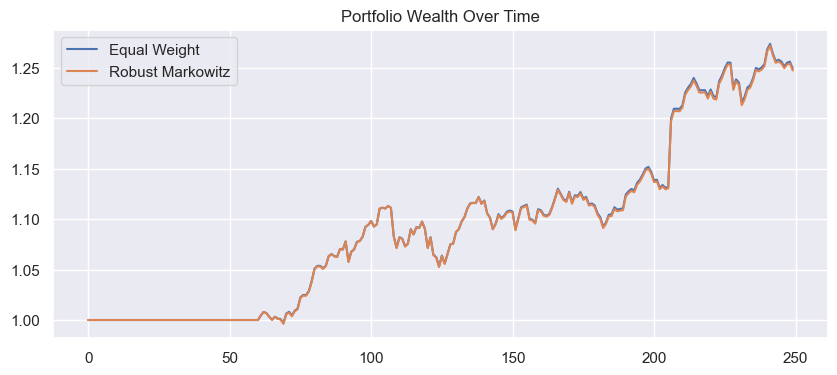

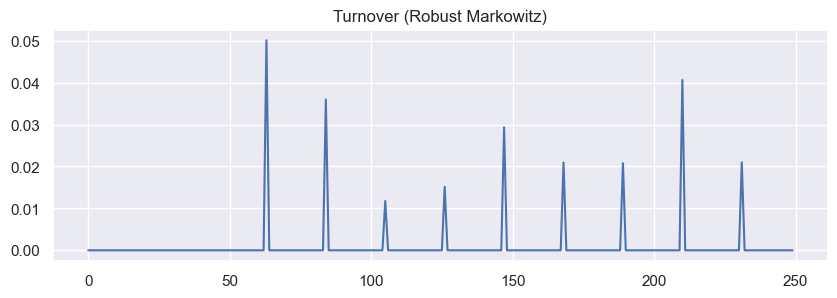

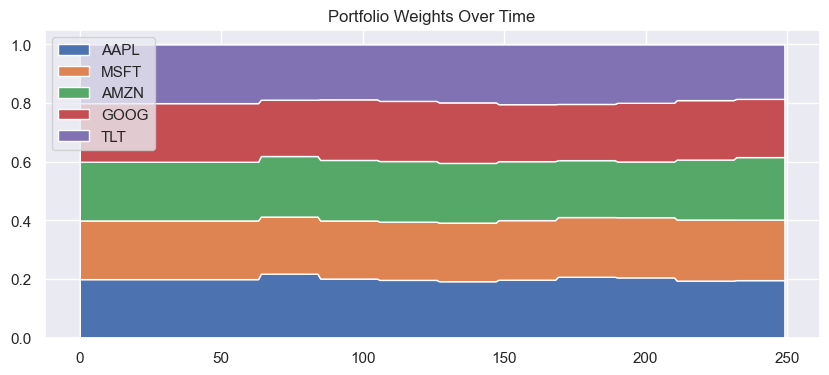


Equal Weights Strategy:
Performance summary
-------------------
Total return:     24.92%
Avg daily return: 0.0009
Daily volatility: 0.0068

Robust Markowitz Strategy:
Performance summary
-------------------
Total return:     24.72%
Avg daily return: 0.0009
Daily volatility: 0.0069


In [67]:
plt.figure(figsize=(10,4))
plt.plot(res_eq["wealth"], label="Equal Weight")
plt.plot(res_rm["wealth"], label="Robust Markowitz")
plt.legend()
plt.title("Portfolio Wealth Over Time")
plt.show()

plt.figure(figsize=(10,3))
plt.plot(res_rm["turnover"])
plt.title("Turnover (Robust Markowitz)")
plt.show()

plt.figure(figsize=(10,4))
plt.stackplot(
    range(len(res_rm["weights"])),
    res_rm["weights"].T,
    labels=tickers
)
plt.legend(loc="upper left")
plt.title("Portfolio Weights Over Time")
plt.show()

# printing final summary about returns from equal weight baseline version and the robust optimization we did
print()
print("Equal Weights Strategy:")
print_performance_summary( wealth=res_eq["wealth"],  returns=res_eq["returns"])
print()
print("Robust Markowitz Strategy:")
print_performance_summary( wealth=res_rm["wealth"], returns=res_rm["returns"])

